In [9]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression

Анализ данных

Просмотр материалов

In [23]:
df_ref = pd.read_csv("data_ref_until_2020-02-13.csv", sep = ',')
df_gas = pd.read_csv("database_gas.csv", sep = ',')
df_pos = pd.read_csv("database_pos.csv", sep = ',')

In [24]:
df_pos.head

<bound method NDFrame.head of                                   datetime  Living room  Bedroom  Bathroom  \
0      2019-11-01 02:52:55.271086300+00:00          NaN      0.0       NaN   
1      2019-11-01 03:19:57.417067700+00:00          NaN      1.0       NaN   
2      2019-11-01 03:21:53.257070700+00:00          NaN      0.0       NaN   
3         2019-11-01 05:11:08.874031+00:00          NaN      1.0       NaN   
4      2019-11-01 05:12:38.437033500+00:00          NaN      0.0       NaN   
...                                    ...          ...      ...       ...   
28473  2020-02-13 17:04:38.956087800+00:00          1.0      NaN       NaN   
28474  2020-02-13 17:05:29.384067600+00:00          NaN      NaN       1.0   
28475  2020-02-13 17:06:21.575053600+00:00          0.0      NaN       NaN   
28476  2020-02-13 17:06:30.519011100+00:00          NaN      NaN       0.0   
28477  2020-02-13 17:06:30.833050100+00:00          NaN      NaN       NaN   

       Kitchen  Hallway  
0      

In [25]:
df_gas.head

<bound method NDFrame.head of                                timestamp  temperature  humidity  \
0       2019-11-06 11:37:13.038174+01:00        19.48     54.86   
1       2019-11-06 11:37:32.744996+01:00        19.59     54.23   
2       2019-11-06 11:37:53.018087+01:00        19.63     54.05   
3       2019-11-06 11:38:13.093151+01:00        19.64     53.74   
4       2019-11-06 11:38:33.032832+01:00        19.67     53.53   
...                                  ...          ...       ...   
416148  2020-02-13 11:56:53.929978+01:00        20.62     57.75   
416149  2020-02-13 11:57:14.204458+01:00        20.62     57.75   
416150  2020-02-13 11:57:33.983249+01:00        20.62     57.75   
416151  2020-02-13 11:57:54.058349+01:00        20.62     57.74   
416152  2020-02-13 11:58:14.014336+01:00        20.62     57.74   

        CO2CosIRValue  CO2MG811Value   MOX1   MOX2   MOX3   MOX4  COValue  
0               128.0          563.0  476.0  731.0  649.0  565.0    128.0  
1            

In [26]:
df_ref.head

<bound method NDFrame.head of                               timestamp  temperature  humidity  CO2CosIRValue  \
0      2020-01-25 00:01:49.251503+01:00        20.64     55.57          121.0   
1      2020-01-25 00:02:09.350082+01:00        20.64     55.53          122.0   
2      2020-01-25 00:02:29.319505+01:00        20.62     55.53          121.0   
3      2020-01-25 00:02:49.399379+01:00        20.62     55.57          121.0   
4      2020-01-25 00:03:09.158989+01:00        20.62     55.59          121.0   
...                                 ...          ...       ...            ...   
75506  2020-02-13 11:56:53.929978+01:00        20.62     57.75           62.0   
75507  2020-02-13 11:57:14.204458+01:00        20.62     57.75           62.0   
75508  2020-02-13 11:57:33.983249+01:00        20.62     57.75           62.0   
75509  2020-02-13 11:57:54.058349+01:00        20.62     57.74           63.0   
75510  2020-02-13 11:58:14.014336+01:00        20.62     57.74           63.0  

Анализ датчиков газа

In [27]:
df_gas['timestamp'] = pd.to_datetime(df_gas['timestamp'])

df_gas['дата'] = df_gas['timestamp'].dt.date
df_gas['время'] = df_gas['timestamp'].dt.time

last_date = df_gas['дата'].max()
first_date = df_gas['дата'].min()

days_difference = (last_date - first_date).days


print(f"количество дней, когда проводились измерения: {days_difference}")

количество дней, когда проводились измерения: 99


In [28]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416153 entries, 0 to 416152
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype                    
---  ------         --------------   -----                    
 0   timestamp      416153 non-null  datetime64[ns, UTC+01:00]
 1   temperature    416153 non-null  float64                  
 2   humidity       416153 non-null  float64                  
 3   CO2CosIRValue  416153 non-null  float64                  
 4   CO2MG811Value  416153 non-null  float64                  
 5   MOX1           416153 non-null  float64                  
 6   MOX2           416153 non-null  float64                  
 7   MOX3           416153 non-null  float64                  
 8   MOX4           416153 non-null  float64                  
 9   COValue        416153 non-null  float64                  
 10  дата           416153 non-null  object                   
 11  время          416153 non-null  object                   
dtypes:

In [29]:
statistics = df_gas.describe().T
statistics['range'] = statistics['max'] / statistics['min']
statistics

,count,mean,std,min,25%,50%,75%,max,range
temperature,416153.0,20.115751,2.295836,13.53,18.64,20.10,21.63,26.14,1.932003
humidity,416153.0,52.236446,4.343208,38.16,49.05,52.31,55.64,69.26,1.814990
CO2CosIRValue,416153.0,102.459415,39.026812,21.00,76.00,105.00,117.00,591.00,28.142857
CO2MG811Value,416153.0,539.086523,34.934361,408.00,510.00,528.00,563.00,632.00,1.549020
MOX1,416153.0,500.289413,49.795030,262.00,468.00,502.00,536.00,626.00,2.389313
MOX2,416153.0,718.708761,31.296907,514.00,703.00,719.00,738.00,808.00,1.571984
MOX3,416153.0,672.788842,36.354293,447.00,655.00,674.00,693.00,777.00,1.738255
MOX4,416153.0,609.446752,42.703923,355.00,587.00,611.00,635.00,727.00,2.047887
COValue,416153.0,120.124310,35.992508,74.00,103.00,113.00,128.00,918.00,12.405405


<Axes: >

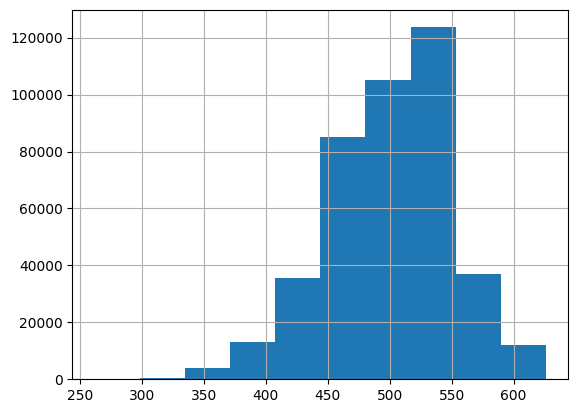

In [30]:
df_gas['MOX1'].hist()

<Axes: >

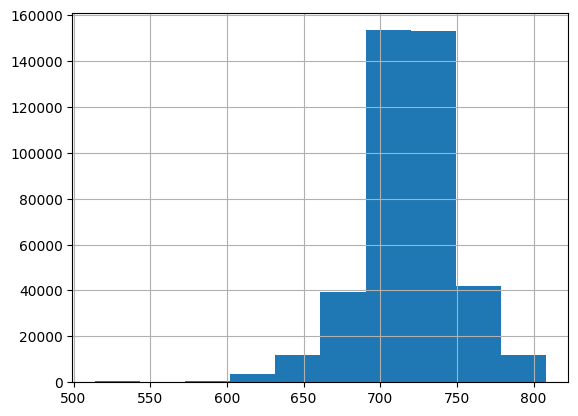

In [31]:
df_gas['MOX2'].hist()

<Axes: >

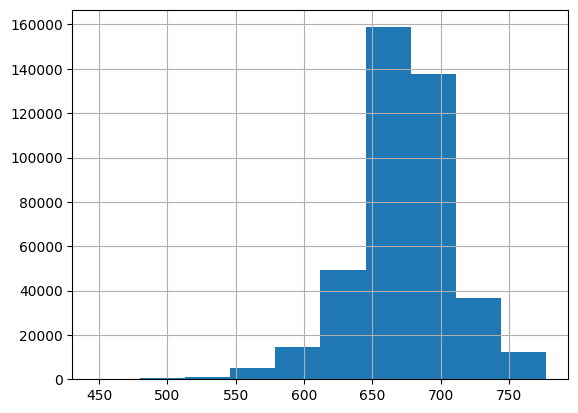

In [32]:
df_gas['MOX3'].hist()

<Axes: >

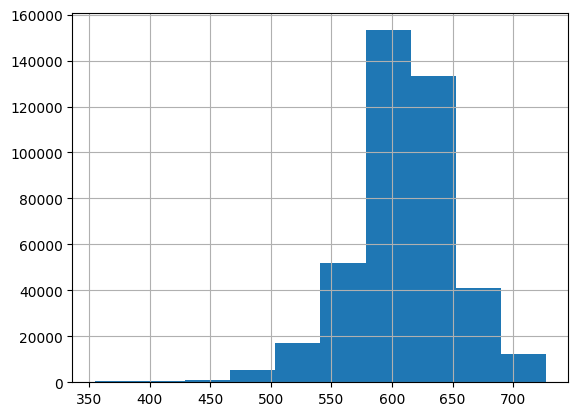

In [33]:
df_gas['MOX4'].hist()

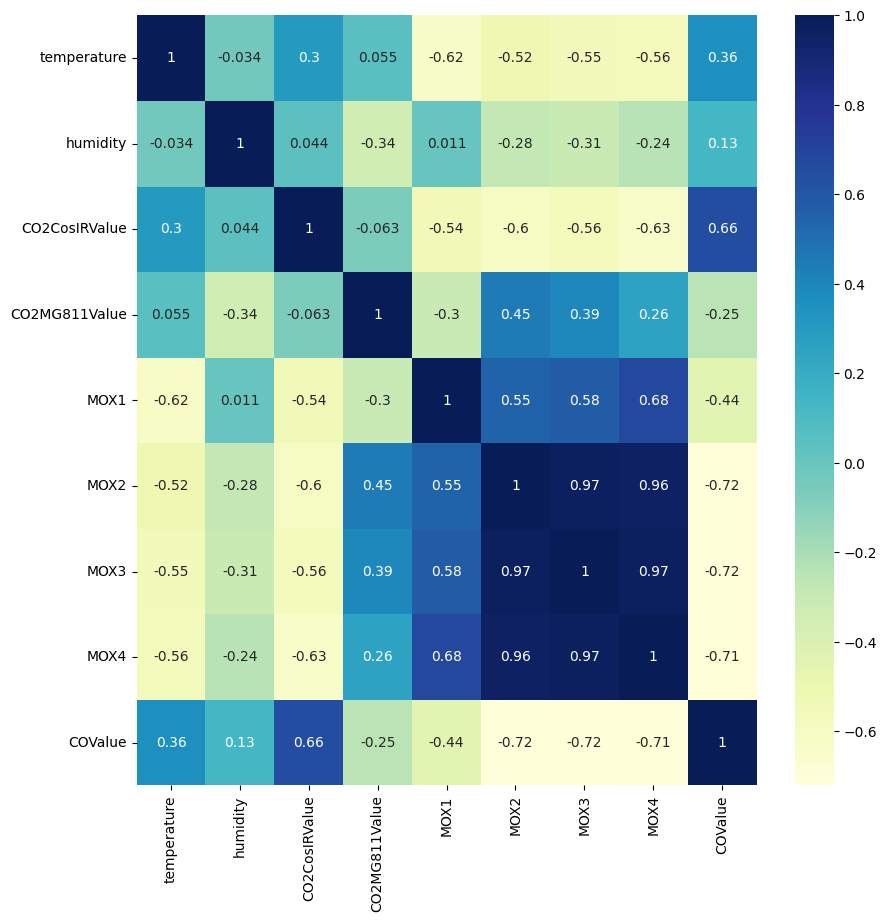

In [37]:
numeric_columns = df_gas.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_gas[numeric_columns].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.show()


На данной диаграме видно, что между собой датчики МОХ2, МОХ3,МОХ4, следовательно их можно можно объелинить в один критерий, так же данные которые относятся к co2 схожи и их так же можно соединить

In [38]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28478 entries, 0 to 28477
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     28478 non-null  object 
 1   Living room  8866 non-null   float64
 2   Bedroom      3161 non-null   float64
 3   Bathroom     5953 non-null   float64
 4   Kitchen      2521 non-null   float64
 5   Hallway      7948 non-null   float64
dtypes: float64(5), object(1)
memory usage: 1.3+ MB


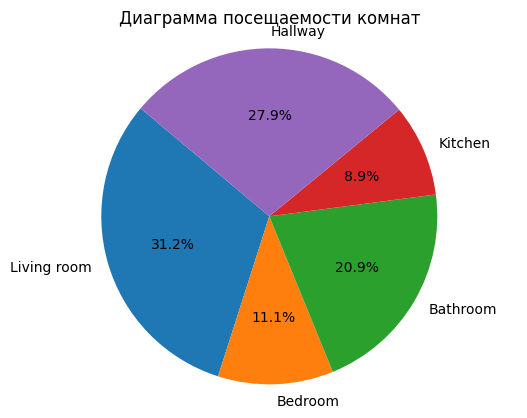

In [39]:
room_counts = df_pos[['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']].sum()

# Построим круговую диаграмму
plt.pie(room_counts, labels=room_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Задаем равные масштабы по осям X и Y
plt.title('Диаграмма посещаемости комнат')
plt.show()

In [40]:
statistics_ref = df_ref.describe().T
statistics_ref['range'] = statistics_ref['max'] / statistics_ref['min']
statistics_ref

,count,mean,std,min,25%,50%,75%,max,range
temperature,75511.0,20.025767,1.404978,14.82,19.94,20.23,20.64,23.47,1.583671
humidity,75511.0,56.690943,2.416317,46.27,55.36,57.03,58.31,69.26,1.496866
CO2CosIRValue,75511.0,70.176226,22.969229,37.00,53.00,69.00,74.00,198.00,5.351351
CO2MG811Value,75511.0,510.003523,9.233296,420.00,502.00,509.00,518.00,526.00,1.252381
MOX1,75511.0,538.731390,21.364820,339.00,530.00,537.00,545.00,598.00,1.764012
MOX2,75511.0,724.035849,19.940654,634.00,710.00,722.00,742.00,791.00,1.247634
MOX3,75511.0,675.748619,22.754632,575.00,663.00,676.00,690.00,734.00,1.276522
MOX4,75511.0,625.210473,27.964882,473.00,611.00,626.00,643.00,690.00,1.458774
COValue,75511.0,114.237290,21.903941,82.00,101.00,109.00,120.00,918.00,11.195122


In [41]:
df_ref['timestamp'] = pd.to_datetime(df_ref['timestamp'])

df_ref['дата'] = df_ref['timestamp'].dt.date
df_ref['время'] = df_ref['timestamp'].dt.time

last_date = df_ref['дата'].max()
first_date = df_ref['дата'].min()

days_difference = (last_date - first_date).days


print(f"количество дней, когда проводились измерения: {days_difference}")

количество дней, когда проводились измерения: 19


Модели

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Загрузка данных из CSV-файла
data = df_gas

# Определение нормы для температуры и углекислого газа
норма_температуры = 30
норма_CO2 = 580

# Создание целевой переменной: 1, если превышение нормы, иначе 0
data['exceeds_norm'] = ((data['temperature'] > норма_температуры) | (data['CO2CosIRValue'] > норма_CO2)).astype(int)

# Разделение данных на признаки (X) и целевую переменную (y)
X = data[['temperature', 'CO2CosIRValue']]
y = data['exceeds_norm']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели логистической регрессии
model = LogisticRegression()

# Обучение модели
model.fit(X_train, y_train)

# Получение предсказаний для тестового набора
predictions = model.predict(X_test)

# Анализ результатов и вывод предупреждений при необходимости
for index, (prediction, actual) in enumerate(zip(predictions, y_test)):
    if prediction == 1 and actual == 1 and (
            data.iloc[X_test.index[index]]['temperature'] > норма_температуры or
            data.iloc[X_test.index[index]]['CO2CosIRValue'] > норма_CO2):
        timestamp = X_test.index[index]
        temp_value = X_test.iloc[index]['temperature']
        co2_value = X_test.iloc[index]['CO2CosIRValue']
        print(f"Предупреждение! Превышение нормы. Время: {timestamp}, Температура: {temp_value}, CO2: {co2_value}")

# Вычисление точности
accuracy = accuracy_score(y_test, predictions)

# Вывод точности
print(f"Точность предсказания: {accuracy * 100:.2f}%")

Предупреждение! Превышение нормы. Время: 207049, Температура: 24.06, CO2: 588.0
Предупреждение! Превышение нормы. Время: 207163, Температура: 24.56, CO2: 586.0
Предупреждение! Превышение нормы. Время: 207057, Температура: 24.02, CO2: 590.0
Предупреждение! Превышение нормы. Время: 207195, Температура: 24.29, CO2: 582.0
Предупреждение! Превышение нормы. Время: 207141, Температура: 24.26, CO2: 587.0
Предупреждение! Превышение нормы. Время: 207150, Температура: 24.38, CO2: 585.0
Предупреждение! Превышение нормы. Время: 207144, Температура: 24.35, CO2: 586.0
Предупреждение! Превышение нормы. Время: 207130, Температура: 24.63, CO2: 586.0
Предупреждение! Превышение нормы. Время: 207127, Температура: 24.67, CO2: 585.0
Предупреждение! Превышение нормы. Время: 207045, Температура: 23.88, CO2: 584.0
Предупреждение! Превышение нормы. Время: 207120, Температура: 24.46, CO2: 584.0
Предупреждение! Превышение нормы. Время: 207166, Температура: 24.58, CO2: 586.0
Предупреждение! Превышение нормы. Время: